In [1]:
import pandas as pd
import sqlite3
import pyodbc
import datetime as datetime
import warnings
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances

In [2]:


DB_SOURCE = {
    'servername': r'LAPTOP-PRQNR6SS\SQLEXPRESS',
    'database': 'SDM'
}



source_conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    f"SERVER={DB_SOURCE['servername']};"
    f"DATABASE={DB_SOURCE['database']};"
    "Trusted_Connection=yes;"
)




source_cursor = source_conn.cursor()



print("Succesvol verbonden met databases!")

Succesvol verbonden met databases!


In [3]:
# Haal een lijst van tabellen op uit de bron-database
sql_query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"


# Gebruik pandas om de query uit te voeren en de tabellen op te halen
tables_df = pd.read_sql(sql_query, source_conn)

# Print de lijst van tabellen
tables_df

,TABLE_NAME
0,returned_item
1,satisfaction_type
2,satisfaction
3,training
4,inventory_levels_train
5,product_forecast_train
6,sales_territory
7,country
8,order_method
9,product_line


In [4]:

product_query = 'SELECT * FROM Product'
product_df = pd.read_sql(product_query, source_conn)

sales_branch_query = 'SELECT * FROM sales_branch'
sales_branch_df = pd.read_sql(sales_branch_query, source_conn)

order_header_query = 'SELECT * FROM order_header'
order_header_df = pd.read_sql(order_header_query, source_conn)

order_details_query = 'SELECT * FROM order_details'
order_details_df = pd.read_sql(order_details_query, source_conn)

In [67]:
branch_order_merge = pd.merge(sales_branch_df, order_header_df, how='left', on='SALES_BRANCH_CODE')

order_merge = pd.merge(branch_order_merge, order_details_df, how='inner', on='ORDER_NUMBER')

last_merge = pd.merge(order_merge, product_df, how='left', on='PRODUCT_NUMBER')

last_merge.columns

Index(['SALES_BRANCH_CODE', 'ADDRESS1', 'ADDRESS2', 'CITY', 'REGION',
       'COUNTRY_CODE', 'ORDER_NUMBER', 'RETAILER_NAME', 'RETAILER_SITE_CODE',
       'RETAILER_CONTACT_CODE', 'SALES_STAFF_CODE', 'ORDER_DATE',
       'ORDER_METHOD_CODE', 'ORDER_DETAIL_CODE', 'PRODUCT_NUMBER', 'QUANTITY',
       'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'INTRODUCTION_DATE',
       'PRODUCT_TYPE_CODE', 'PRODUCTION_COST', 'MARGIN', 'PRODUCT_IMAGE',
       'LANGUAGE', 'PRODUCT_NAME', 'DESCRIPTION'],
      dtype='object')

In [75]:
df = last_merge.loc[:, ['SALES_BRANCH_CODE', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'PRODUCTION_COST', 'QUANTITY', 'CITY', 'COUNTRY_CODE', 'SALES_STAFF_CODE', 'ORDER_NUMBER', 'MARGIN']]

df.drop_duplicates()
df

,SALES_BRANCH_CODE,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST,QUANTITY,CITY,COUNTRY_CODE,SALES_STAFF_CODE,ORDER_NUMBER,MARGIN
0,6,69.660004,104.480003,104.480003,65.330002,10,Paris,1,7,2259,0.33
1,6,83.370003,116.730003,116.730003,78.550003,22,Paris,1,7,2259,0.28
2,6,500.670013,650.890015,572.719971,473.070007,64,Paris,1,7,2260,0.23
3,6,43.220001,73.500000,73.500000,41.180000,36,Paris,1,5,2261,0.40
4,6,541.630005,677.030029,643.190002,476.000000,44,Paris,1,5,2262,0.20
...,...,...,...,...,...,...,...,...,...,...,...
37752,39,19.520000,39.040001,36.110001,20.000000,64,Wien,5,124,7470,0.50
37753,39,46.520000,79.110001,74.220001,47.060001,44,Wien,5,124,7470,0.40
37754,39,41.990002,83.980003,77.680000,40.000000,28,Wien,5,124,7470,0.50
37755,39,177.169998,301.200012,282.600006,176.470001,20,Wien,5,124,7470,0.40


## Clustering van Branches op basis van hoeveelheid producten

In [61]:
df = df.loc[:, ['SALES_BRANCH_CODE', 'QUANTITY']]
df_1 = df.groupby(['SALES_BRANCH_CODE']).agg({'QUANTITY': 'sum'}).reset_index()

df_1


,SALES_BRANCH_CODE,QUANTITY
0,6,80124
1,7,102896
2,9,115446
3,13,91830
4,14,104542
5,15,140084
6,17,60684
7,18,151714
8,19,79286
9,20,68450


In [62]:

# 4. Schalen van de data
scaler = StandardScaler()
X = scaler.fit_transform(df_1[['QUANTITY']])

###


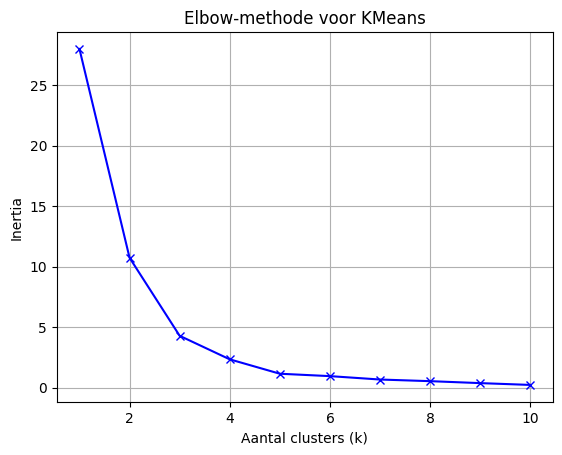

In [63]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Aantal clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow-methode voor KMeans')
plt.grid(True)
plt.show()

In [64]:

kmeans = KMeans(n_clusters = 3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)


In [65]:
print(df)

    SALES_BRANCH_CODE  QUANTITY  cluster
0                   6     80124        0
1                   7    102896        2
2                   9    115446        2
3                  13     91830        0
4                  14    104542        2
5                  15    140084        2
6                  17     60684        0
7                  18    151714        2
8                  19     79286        0
9                  20     68450        0
10                 21     73290        0
11                 22     29898        1
12                 23     59500        0
13                 24     53948        1
14                 25     17622        1
15                 26     41702        1
16                 28     53172        1
17                 29     68660        0
18                 30     82364        0
19                 31     47750        1
20                 32     33704        1
21                 33     37770        1
22                 34     39016        1
23              

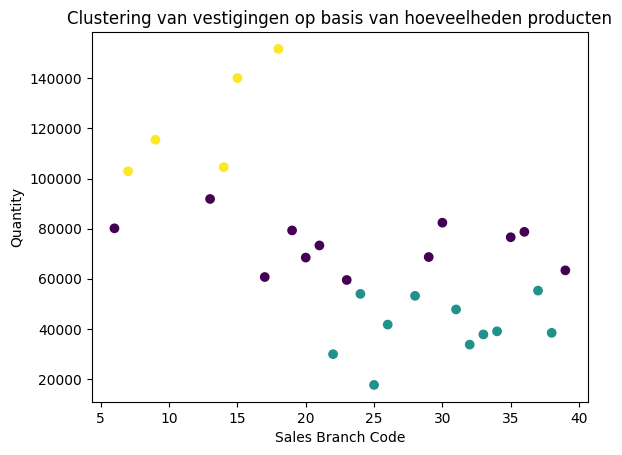

In [66]:
plt.scatter(df_1['SALES_BRANCH_CODE'], df_1['QUANTITY'], c=df['cluster'], cmap='viridis')
plt.xlabel('Sales Branch Code')
plt.ylabel('Quantity')
plt.title('Clustering van vestigingen op basis van hoeveelheden producten')
plt.show()

## Clustering Branches op verkoop prijs en aantal orders

In [77]:
df_2 = df.loc[:, ['SALES_BRANCH_CODE', 'QUANTITY', 'UNIT_SALE_PRICE', 'ORDER_NUMBER', 'MARGIN']]
df_2 = df_2.groupby(['SALES_BRANCH_CODE']).agg(
    {'QUANTITY': 'sum',
     'MARGIN' : 'mean',
     'UNIT_SALE_PRICE': 'mean',
     'ORDER_NUMBER': 'nunique'}
).rename(columns={
    'QUANTITY': 'Total_Quantity',
    'MARGIN': 'Avg_Margin',
    'UNIT_SALE_PRICE': 'Avg_Price',
    'ORDER_NUMBER': 'Total_Orders'
}).reset_index()
df_2

,SALES_BRANCH_CODE,Total_Quantity,Avg_Margin,Avg_Price,Total_Orders
0,6,80124,0.393376,130.869864,193
1,7,102896,0.388119,144.718446,155
2,9,115446,0.389427,139.296528,249
3,13,91830,0.394553,147.842409,245
4,14,104542,0.395318,161.412844,206
5,15,140084,0.391327,133.704124,254
6,17,60684,0.376397,127.456609,110
7,18,151714,0.400796,170.578687,296
8,19,79286,0.388644,136.074131,457
9,20,68450,0.390358,148.631697,303


In [119]:
scaler = StandardScaler()
X = scaler.fit_transform(df_2[['Total_Quantity', 'Avg_Margin', 'Avg_Price', 'Total_Orders']])


In [136]:
# 4. Clustering toepassen
kmeans2 = KMeans(n_clusters=3, random_state=42)
df_2['Cluster'] = kmeans2.fit_predict(X)

In [108]:
print(df_2)

    SALES_BRANCH_CODE  Total_Quantity  Avg_Margin   Avg_Price  Total_Orders  \
0                   6           80124    0.393376  130.869864           193   
1                   7          102896    0.388119  144.718446           155   
2                   9          115446    0.389427  139.296528           249   
3                  13           91830    0.394553  147.842409           245   
4                  14          104542    0.395318  161.412844           206   
5                  15          140084    0.391327  133.704124           254   
6                  17           60684    0.376397  127.456609           110   
7                  18          151714    0.400796  170.578687           296   
8                  19           79286    0.388644  136.074131           457   
9                  20           68450    0.390358  148.631697           303   
10                 21           73290    0.386701  164.930126           342   
11                 22           29898    0.401700  1

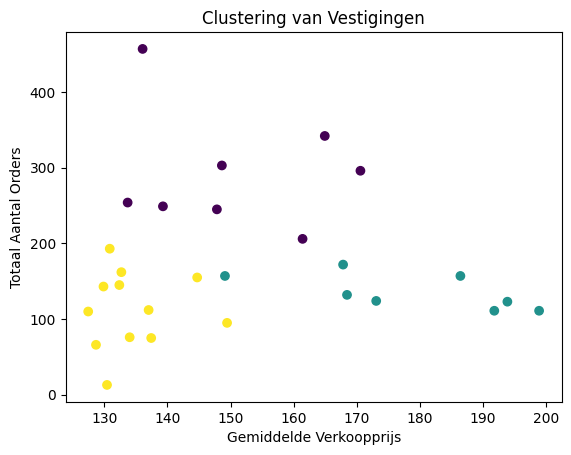

In [137]:
plt.scatter(df_2['Avg_Price'], df_2['Total_Orders'], c=df_2['Cluster'], cmap='viridis')
plt.xlabel('Gemiddelde Verkoopprijs')
plt.ylabel('Totaal Aantal Orders')
plt.title('Clustering van Vestigingen')
plt.show()

In [138]:
kmeans_centra2 = pd.DataFrame(kmeans2.cluster_centers_)

for i in range(len(kmeans_centra2.columns)):
    kmeans_centra2 = kmeans_centra2.rename(columns = {i : f'{df_2.columns[1+i]}'})

kmeans_centra2 = kmeans_centra2[['Avg_Price', 'Total_Orders']]
kmeans_centra2

,Avg_Price,Total_Orders
0,-0.063077,1.311443
1,1.243999,-0.372552
2,-0.787281,-0.625927


In [139]:
for src_index, _ in df_2.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra2.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra2.columns:
            current_difference = df_2.at[src_index, column_name] - kmeans_centra2.at[centrumindex, column_name]
            print(f'\t\t{df_2.at[src_index, column_name]} - {kmeans_centra2.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2

        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')

    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2.at[src_index, 'Centrum'] = centrum_number
    print("================================================")



Afstand van bronindex 0 tot...
	Centrumindex 0:
		130.8698644845382 - -0.06307676552731205 = 130.9329412500655
		193 - 1.3114426638640815 = 191.68855733613591
	Totale euclidische som: 53887.938118002174
	Euclidische afstand: 232.13775676955737
------------------------------------------------
	Centrumindex 1:
		130.8698644845382 - 1.2439986485553147 = 129.6258658359829
		193 - -0.37255165001591306 = 193.3725516500159
	Totale euclidische som: 54195.80882536631
	Euclidische afstand: 232.799933044162
------------------------------------------------
	Centrumindex 2:
		130.8698644845382 - -0.7872812553519978 = 131.65714573989018
		193 - -0.6259273425654458 = 193.62592734256543
	Totale euclidische som: 54824.603763643114
	Euclidische afstand: 234.14654335189985
------------------------------------------------
{0: 232.13775676955737, 1: 232.799933044162, 2: 234.14654335189985}
0
Afstand van bronindex 1 tot...
	Centrumindex 0:
		144.71844646411367 - -0.06307676552731205 = 144.78152322964098
		1